<a href="https://colab.research.google.com/github/KSY1526/myblog/blob/master/_notebooks/kagglessu5_plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 따릉이 데이터 예측 코드

# 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

train = pd.read_csv("/content/drive/MyDrive/bicycle/train.csv")
test = pd.read_csv('/content/drive/MyDrive/bicycle/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/bicycle/sample_submission.csv')
train.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833


# 변수 탐색

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_time                  273 non-null    object 
 1   wind_direction             273 non-null    float64
 2   sky_condition              273 non-null    float64
 3   precipitation_form         273 non-null    float64
 4   wind_speed                 273 non-null    float64
 5   humidity                   273 non-null    float64
 6   low_temp                   273 non-null    float64
 7   high_temp                  273 non-null    float64
 8   Precipitation_Probability  273 non-null    float64
 9   number_of_rentals          273 non-null    int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 21.5+ KB


number_of_rentals : 따릉이 대여량(Y값), date_time : 날짜, wind_direction : 풍향

sky_condition : 하늘 상태(1 : 맑음, 3 : 구름 많음, 4 : 흐림, 하루에 8번 측정한 값 평균)

precipitation_form : 강수 형태(0 : 맑음, 1 : 비, 마찬가지로 하루에 8번 측정한 값 평균)

wind_speed : 풍속, humidity	: 습도, low_temp : 최저기온, high_temp : 최고기온, precipitation_Probability : 강수확률

결측값은 없습니다.


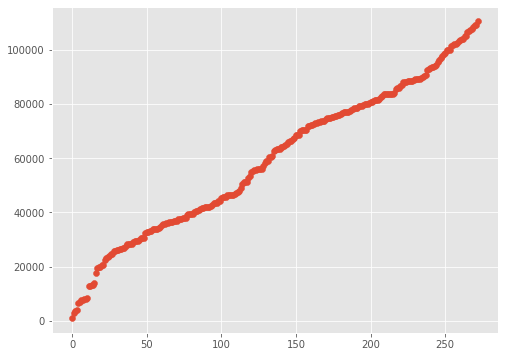

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train['number_of_rentals'].values))
plt.show()

반응변수의 이상치은 관찰되지 않는 것으로 보입니다.

In [ ]:
train['date_time'] = pd.to_datetime(train['date_time'])
test['date_time'] = pd.to_datetime(test['date_time'])

train['day']=pd.DatetimeIndex(train['date_time']).day
test['day']=pd.DatetimeIndex(test['date_time']).day
train['month']=pd.DatetimeIndex(train['date_time']).month
test['month']=pd.DatetimeIndex(test['date_time']).month
train['year']=pd.DatetimeIndex(train['date_time']).year
test['year']=pd.DatetimeIndex(test['date_time']).year
train['weekday']=pd.DatetimeIndex(train['date_time']).weekday
test['weekday']=pd.DatetimeIndex(test['date_time']).weekday

date_time이 날짜 변수이기 때문에 데이터 형식을 datetime으로 바꾸어줍니다.

그 후 datetime 데이터 형식으로 얻을 수 있는 이점. 날/달/년/주말 변수를 추출합니다.

321.622

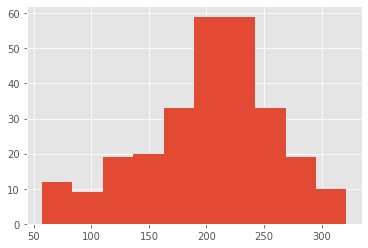

In [ ]:
train['wind_direction'].hist()
train['wind_direction'].max()

wind_direction은 바람 방향 변수입니다. 아마 방향을 360도로 생각해서 만든 변수인 것 같습니다.

다만 바람 방향이 과연 따릉이 대여량과 상관이 있지는 않을 것으로 저는 생각합니다.

서울 자전거 도로가 한강 기준으로 많이 구성되어 있어 도로가 동-서 기준으로 많이 있긴 합니다.

하지만 바람 방향이 오늘은 이쪽이니 자전거를 타자라는 생각을 더 한다는게 공감하기 힘듭니다. 바람 세기가 더 중요하죠.

또 아마 바람 방향은 계속 바뀌기 때문에 평균적인 방향인 것 같은데, 만약 바람이 주로 0에서 20, 340에서 360 각도로 불었을때 평균치는 약 180입니다.

(방향이 동쪽에서 위 아래로만 움직인다면 10에서 350으로 쉽게 바뀔 수 있습니다.)

이 수치가 과연 유의미할지 개인적으로 의문이 들어서 실험은 다양하게 하겠지만 이 변수는 빼는 것이 좋아보입니다.

In [ ]:
train['precipitation_form'].corr(train['Precipitation_Probability'])

0.9106089542607185

In [ ]:
train['precipitation_form'].corr(train['sky_condition'])

0.6738137525457335

비가 오는 상황을 예측하는 두 변수 precipitation_form와 Precipitation_Probability간 상관관계는 당연히 높습니다.

다만 Precipitation_Probability는 강우 확률 예측 변수 입니다.

때문에 일일 강우 단기예측 기록인 precipitation_form 변수가 하루 비가 오는 날을 더 잘 표현할 것으로 생각됩니다.

비슷한 부분을 설명하는 두 변수이기 때문에 precipitation_form 변수만 사용하겠습니다.

precipitation_form 변수는 하늘 상태를 나타내는 sky_condition 변수와도 상관관계가 높지만 극단적이진 않습니다.

날씨가 흐린것 자체가 따릉이 대여량에 부정적인 영향을 받는다 생각하기 때문에 sky_condition 변수는 사용하겠습니다.

<BarContainer object of 91 artists>

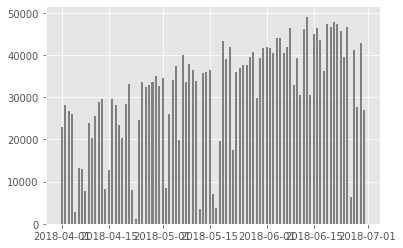

In [ ]:
import matplotlib.pyplot as plt

plt.bar(train['date_time'][train['year'] == 2018], train['number_of_rentals'][train['year'] == 2018], width=0.6, color='grey')

In [ ]:
train['day'][train['month'] == 5] += 30
train['day'][train['month'] == 6] += 61

test['day'][test['month'] == 5] += 30
test['day'][test['month'] == 6] += 61

따릉이 대여량을 2018년 기준으로 날짜순으로 확인했습니다.

4~6월 데이터인 만큼, 날이 점점 따뜻해지는 영향으로 변동이 심하긴 하지만 증가하는 추세가 보이는 것 같습니다.

(중간중간 값이 급격히 작아지는 것은 아마 비가 오는날인거 같습니다.)

그래서 날짜 변수를 쓰는것 보다, 누적된 날짜가 몇일인지를 기록하는 변수를 쓰는게 좋을 것 같습니다.

(5월 2일 => 32일, 6월 10일 => 30일 + 31일 + 10일 = 71일)

이렇게 되면 달 변수 또한 쓰지 않는게 좋을 것 같습니다. 만든 변수가 달 변수가 설명할 부분까지 설명하기 때문이죠.

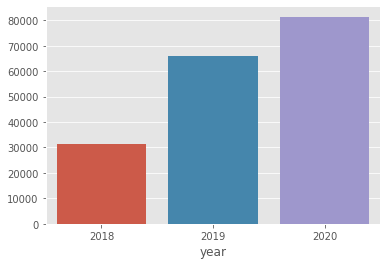

In [ ]:
import seaborn as sns

def barplots(variable):
    plot = train.groupby(variable)['number_of_rentals'].mean()
    sns.barplot(plot.index,plot.values)
barplots('year')

연도별 따릉이 이용자수를 나타내는 그래프 입니다.

시간이 지날수록 따릉이 이용자수가 늘어나는 것을 확인할 수 있습니다. 그러므로 연도 변수는 매우 중요한 변수임을 알 수 있겠죠.

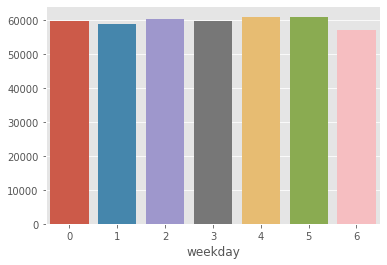

In [ ]:
barplots('weekday')

요일별 따릉이 이용자수를 나타내는 그래프 입니다. weekday 변수는 0은 월요일, 6은 일요일을 나타내는 요일 변수입니다. 

직관적으로 확인했을때 일요일에 따릉이 이용자수가 유의미하게 적은 것이 눈에 띕니다.

In [ ]:
train_label = train['number_of_rentals']
train.drop(['date_time','wind_direction', 'Precipitation_Probability', 'month', 'number_of_rentals'], axis = 1, inplace= True)
test.drop(['date_time','wind_direction', 'Precipitation_Probability', 'month'], axis = 1, inplace= True)

앞서 설명한 변수들을 제거합니다.

# 모델 적합

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 0, n_estimators = 100)
rf.fit(train,train_label)
sample_submission['number_of_rentals'] = rf.predict(test)
sample_submission.to_csv('bicycle_final_4.csv',encoding='UTF-8',index=False)

간단한 랜덤 포레스트 모델을 사용했습니다. 다른 모델을 사용하거나 하이퍼 파라미터를 조정하면 점수가 더 오를수도 있겠죠?